In [2]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("kopje.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]


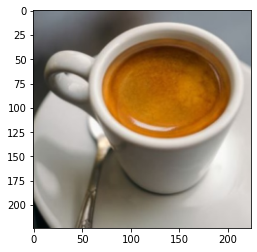

In [4]:

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))


In [5]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();


In [6]:
pred = model(norm(pig_tensor))

In [7]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])


espresso


## Creating an adversary example

In [8]:
import torch.optim as optim
epsilon = 2./255

train_against_label = 967
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([train_against_label]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,train_against_label].item())

pig_adversarial = (pig_tensor + delta).data.clamp_(0,1)

0 -0.0644783303141594
5 -15.765530586242676
10 -20.666391372680664
15 -17.98609733581543
20 -21.81588363647461
25 -16.383914947509766
True class probability: 7.269905122342379e-09


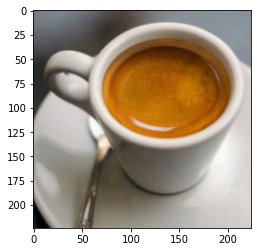

In [8]:

# plot adversary image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_adversarial[0].detach().numpy().transpose(1,2,0))


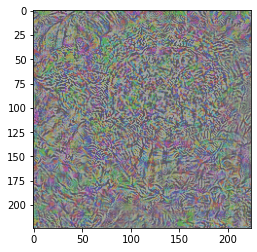

In [23]:

# plot delta (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow((20*delta+0.5)[0].detach().numpy().transpose(1,2,0))


In [10]:
# Prediction
pred_adv = model(norm(pig_adversarial))
print(imagenet_classes[pred_adv.max(dim=1)[1].item()])


consomme


## A targeted attack

In [11]:
train_against_label = 967
target_label = 954
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([train_against_label])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([target_label])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

    
print("Done.")

pig_targeted_adversarial = (pig_tensor + delta).data.clamp_(0,1)

0 15.573756217956543
10 2.0693702697753906
20 -2.8760910034179688
30 -13.167016983032227
40 -23.850631713867188
50 -29.545848846435547
60 -31.358657836914062
70 -39.542728424072266
80 -40.629844665527344
90 -44.60260009765625
Done.


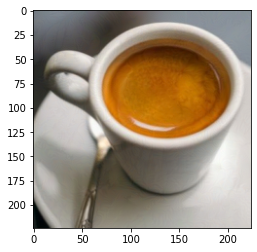

In [12]:

# plot adversary image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_targeted_adversarial[0].detach().numpy().transpose(1,2,0))


In [13]:
# Prediction
pred = model(norm(pig_targeted_adversarial))
max_class = pred.max(dim=1)[1].item()
print(imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

banana
Predicted probability: 0.9999815225601196


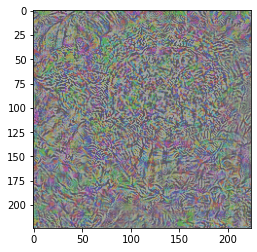

In [21]:

# plot delta (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow((20*delta+0.5)[0].detach().numpy().transpose(1,2,0))


## Anti-adversarial

In [15]:
#Generate a bit of noise
import numpy as np
noise = torch.from_numpy(np.random.normal(0, 1.5e-2, pig_tensor.shape)).float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


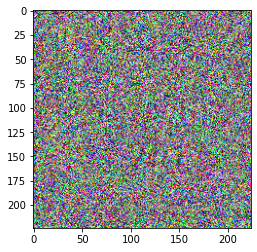

In [22]:

# plot noise
plt.imshow((20*(delta + noise)+0.5)[0].detach().numpy().transpose(1,2,0))


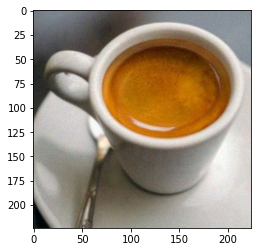

In [17]:

# Adversarial pig with random noise
anti_adversarial = (pig_targeted_adversarial + noise).data.clamp_(0,1)
plt.imshow(anti_adversarial[0].detach().numpy().transpose(1,2,0))


In [18]:
# Prediction
pred2 = model(norm(pig_tensor + delta + noise))
max_class = pred2.max(dim=1)[1].item()
print(imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred2)[0,max_class].item())

espresso
Predicted probability: 0.6951844096183777
